In [32]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import concat_imgs
from nilearn.glm import threshold_stats_img
from pathlib import Path
from nilearn.glm import threshold_stats_img
from nilearn.image import new_img_like
import nibabel as nib
from nilearn.image import math_img
import os, re, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference
from nilearn import image
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.image import load_img, resample_to_img
from sklearn.model_selection import LeaveOneGroupOut
from nilearn.decoding import Decoder
from sklearn.metrics import classification_report
import numpy as np, pandas as pd
from nilearn import datasets, image
from nilearn.input_data import NiftiMasker
from nilearn.decoding import Decoder
from sklearn.model_selection import StratifiedGroupKFold
from nilearn import image, datasets, masking
from nilearn.image import resample_to_img, load_img
from nilearn.plotting import plot_roi, show
from nilearn import datasets, image, masking
from nilearn.image import resample_to_img
from nilearn.masking import intersect_masks
import glob

In [33]:
BASE = "/local/anpa/ds003242-1.0.0"
DERIVATIVES = f"{BASE}/derivatives/"
DERIVATIVES_FMRIPREP = f"{DERIVATIVES}/fmriprep/" 
FIRST_LEVEL_SEP_RUNS = f"{DERIVATIVES}/firstlevel_separate_runs/"  
TASK = "CIC"
TR = 2.0

In [34]:
def resample_mask_to_bold(anat_mask, bold_img):
    """Resample anat mask to the space of the bold image.
    As in tutorial https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html
    """
    return resample_to_img(
        anat_mask,
        bold_img,
        interpolation="nearest",
        copy_header=True,
        force_resample=True,
    )

def fprep_func_dir(sub):
    return Path(BASE)/f"derivatives/fmriprep/sub-{sub}/func"

In [35]:
all_sub_dirs = sorted([p.name.split("sub-")[-1] for p in Path(FIRST_LEVEL_SEP_RUNS).glob("sub-*") if p.is_dir()])
all_sub_dirs[:3]

['SAXSISO01b', 'SAXSISO01f', 'SAXSISO01s']

In [36]:
fasting_participants = [s for s in all_sub_dirs if s.endswith("f")]
social_participants = [s for s in all_sub_dirs if s.endswith("s")]
baseline_participants = [s for s in all_sub_dirs if s.endswith("b")]

In [37]:
fasting_food = [
    f
    for s in fasting_participants
    for f in Path(f"{FIRST_LEVEL_SEP_RUNS}/sub-{s}").rglob("*Food_*_zmap.nii.gz")]
fasting_social = [
    f
    for s in fasting_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
fasting_control = [
    f
    for s in fasting_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]


social_food = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Food_*_zmap.nii.gz")]
social_social = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
social_control = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]


baseline_food = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Food_*_zmap.nii.gz")]
baseline_social = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
baseline_control = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]

In [38]:
def get_data(labels: tuple, z_maps: tuple):

    assert len(labels) == len(z_maps), "Labels and z_maps must have the same length"

    X = np.array([])
    y = np.array([])
    groups = np.array([])

    for label, zmap in zip(labels,z_maps):
        runs = [str(f).split('/')[-1][0] for f in zmap]
        labels = [label] * len(zmap)
        X = np.concatenate((X, np.array(zmap))) if X.size else np.array(zmap)
        y = np.concatenate((y, np.array(labels))) if y.size else np.array(labels)
        groups = np.concatenate((groups, np.array(runs))) if groups.size else np.array(runs)

    return X, y, groups

In [39]:
def compare(labels: tuple, z_maps: tuple, mask=None, standardize=False):

    assert len(labels) == len(z_maps), "Labels and z_maps must have the same length"

    X = np.array([])
    y = np.array([])
    groups = np.array([])

    for label, zmap in zip(labels,z_maps):
        runs = [str(f).split('/')[-1][0] for f in zmap]
        labels = [label] * len(zmap)
        X = np.concatenate((X, np.array(zmap))) if X.size else np.array(zmap)
        y = np.concatenate((y, np.array(labels))) if y.size else np.array(labels)
        groups = np.concatenate((groups, np.array(runs))) if groups.size else np.array(runs)

    decoder = Decoder(t_r=TR, estimator='svc', scoring='accuracy', mask=mask, standardize=standardize, cv=LeaveOneGroupOut(), n_jobs=-1)
    decoder.fit(X, y, groups=groups)

    classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
    print(
        f"Classification accuracy: {classification_accuracy:.4f} / "
    )

    for label, scores in decoder.cv_scores_.items():
        print(label, np.mean(scores))

    return decoder, (X, y)

# Fasting day. 3 way classification

In [40]:
decoder_f, data_f = compare(('Food', 'Social', 'Control'), (fasting_food, fasting_social, fasting_control), mask=None, standardize=False)

# Classification accuracy: 0.9011 / 
# Control 0.8220392771804063
# Food 0.9045512246117084
# Social 0.9765905017921145

Classification accuracy: 0.9011 / 
Control 0.8220392771804063
Food 0.9045512246117084
Social 0.9765905017921145


In [41]:
X,y = data_f

In [42]:
ref = load_img(X[0])  # one of z-maps (target grid)

# collect the fMRIPrep masks that match the space of z-maps (e.g., MNI152NLin2009cAsym)
mask_paths = sorted(glob.glob(f"{DERIVATIVES_FMRIPREP}/sub-*/func/*space-MNI152NLin2009cAsym*desc-brain_mask.nii.gz"))

# build a group mask (voxels present in >=30% of individual masks)
group_mask = intersect_masks(mask_paths, threshold=0.3)
brain_mask = resample_to_img(group_mask, ref, interpolation="nearest")

/tmp/ipykernel_2638728/1060763186.py:8: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  brain_mask = resample_to_img(group_mask, ref, interpolation="nearest")
/tmp/ipykernel_2638728/1060763186.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  brain_mask = resample_to_img(group_mask, ref, interpolation="nearest")


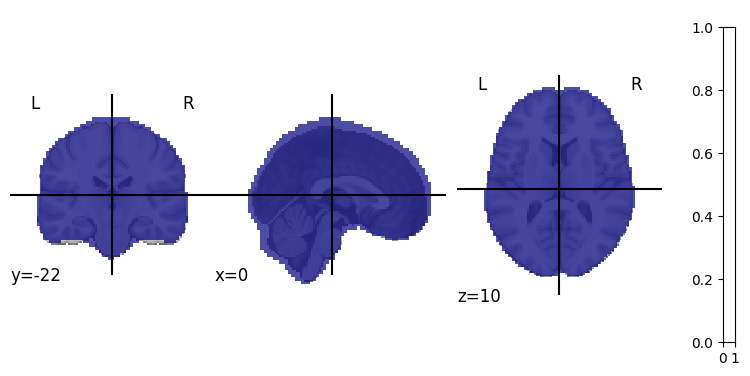

In [43]:
plot_roi(brain_mask)

In [47]:
# 1) atlas → ref grid
ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
labels3d = image.resample_to_img(ho.maps, ref, interpolation="nearest")

visual_terms = ("Occipital","Lingual","Cuneal","Calcarine","Fusiform",
                "Temporal Occipital","Lateral Occipital")
visual_idxs = [i for i, lab in enumerate(ho.labels) if any(t in lab for t in visual_terms)]

visual_mask = image.math_img(" + ".join([f"(img=={i})" for i in visual_idxs]), img=labels3d)
visual_mask = image.math_img("img > 0", img=visual_mask)  # binarize

# 2) both now match ref → safe boolean ops
nonvisual_mask = image.math_img("(bm > 0) & (vm == 0)", bm=brain_mask, vm=visual_mask)

[fetch_atlas_harvard_oxford] Dataset found in /home/anpa/nilearn_data/fsl


/tmp/ipykernel_2638728/3522176511.py:3: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  labels3d = image.resample_to_img(ho.maps, ref, interpolation="nearest")
/tmp/ipykernel_2638728/3522176511.py:3: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  labels3d = image.resample_to_img(ho.maps, ref, interpolation="nearest")


In [48]:
for i in visual_idxs:
    print(ho.labels[i])

Lateral Occipital Cortex, superior division
Lateral Occipital Cortex, inferior division
Cuneal Cortex
Lingual Gyrus
Temporal Fusiform Cortex, anterior division
Temporal Fusiform Cortex, posterior division
Temporal Occipital Fusiform Cortex
Occipital Fusiform Gyrus
Occipital Pole


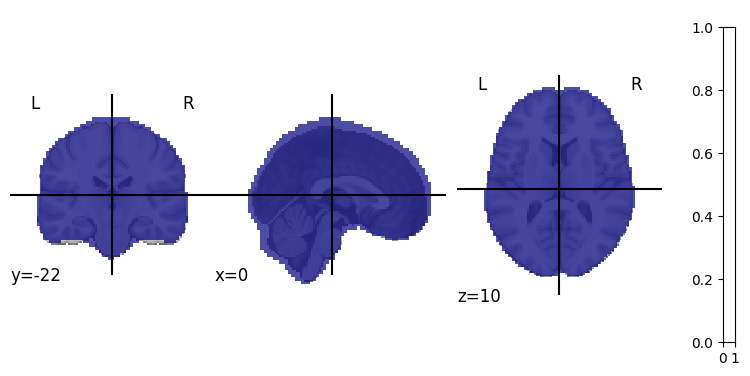

In [49]:
plot_roi(group_mask)

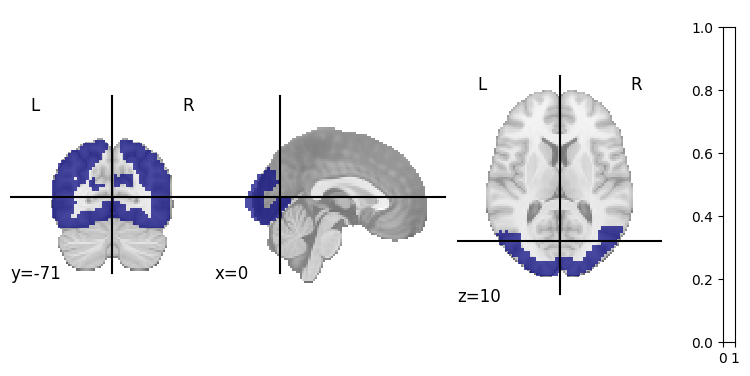

In [50]:
plot_roi(visual_mask)

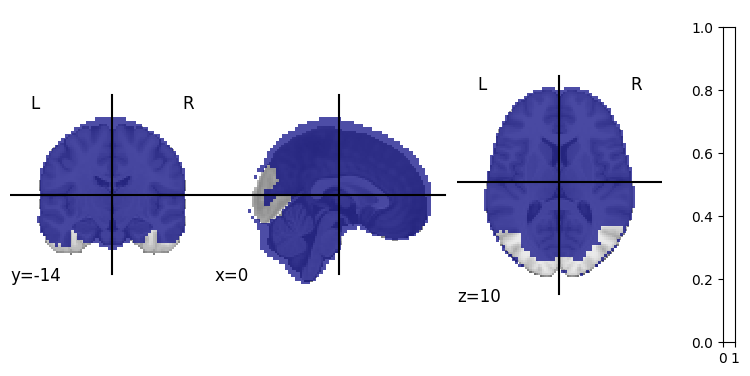

In [51]:
plot_roi(nonvisual_mask)

In [52]:
print(ref.shape, brain_mask.shape, visual_mask.shape, nonvisual_mask.shape)  # all equal

(65, 77, 60) (65, 77, 60) (65, 77, 60) (65, 77, 60)


In [ ]:
decoder__visual_mask, data_f_visual_mask = compare(('Food', 'Social', 'Control'), (fasting_food, fasting_social, fasting_control), mask=visual_mask, standardize=False)


# Classification accuracy: 0.8839 / 
# Control 0.7968936678614099
# Food 0.8736185782556752
# Social 0.9812201314217442

In [54]:
decoder__visual_mask, data_f_visual_mask = compare(('Food', 'Social', 'Control'), (fasting_food, fasting_social, fasting_control), mask=nonvisual_mask, standardize=False)



# Classification accuracy: 0.8734 / 
# Control 0.7956989247311829
# Food 0.877650836320191
# Social 0.9467592592592592

/local/anpa/.conda/envs/py39/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  358   365   665 ... 59459 59480 59505] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/local/anpa/.conda/envs/py39/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/local/anpa/.conda/envs/py39/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  358   365   665 ... 59459 59480 59505] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/local/anpa/.conda/envs/py39/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/local/anpa/.conda/envs/py39/lib/python3.9/site-packages/sklearn/feature_selection/_univaria

Classification accuracy: 0.8734 / 
Control 0.7956989247311829
Food 0.877650836320191
Social 0.9467592592592592


# Lets take nonvisual mask and do cross classification

# Food vs Control on fasting day VS Social pictures vs Control on social isolation day

In [21]:
def compare(labels: tuple, z_maps: tuple, mask):

    assert len(labels) == len(z_maps), "Labels and z_maps must have the same length"

    X = np.array([])
    y = np.array([])
    groups = np.array([])

    for label, zmap in zip(labels,z_maps):
        runs = [str(f).split('/')[-1][0] for f in zmap]
        labels = [label] * len(zmap)
        X = np.concatenate((X, np.array(zmap))) if X.size else np.array(zmap)
        y = np.concatenate((y, np.array(labels))) if y.size else np.array(labels)
        groups = np.concatenate((groups, np.array(runs))) if groups.size else np.array(runs)

    decoder = Decoder(t_r=TR, estimator='svc', scoring='accuracy', mask=mask, standardize=True, cv=LeaveOneGroupOut(), n_jobs=-1)
    decoder.fit(X, y, groups=groups)

    classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
    print(
        f"Classification accuracy: {classification_accuracy:.4f} / "
    )

    for label, scores in decoder.cv_scores_.items():
        print(label, np.mean(scores))

    return decoder, (X, y)

In [ ]:
decoder_ff_fc, data_ff_fc = compare(('Food', 'Control'), (fasting_food, fasting_control), nonvisual_mask)

# Classification accuracy: 0.8321 / 
# Control 0.8321012544802868
# Food 0.8321012544802868

In [ ]:
decoder_ss_sc, data_ss_sc = compare(('Social', 'Control'), (social_social, social_control), nonvisual_mask)

# Classification accuracy: 0.9141 / 
# Control 0.9140625
# Social 0.9140625

In [24]:
y_pred = decoder_ff_fc.predict(data_ss_sc[0])
y_pred[y_pred == 'Food'] = "Social"

y_true = data_ss_sc[1]

print(classification_report(y_true, y_pred, target_names=['Control', '(Food) Social']))

               precision    recall  f1-score   support

      Control       0.51      0.53      0.52       576
(Food) Social       0.52      0.50      0.51       576

     accuracy                           0.51      1152
    macro avg       0.51      0.51      0.51      1152
 weighted avg       0.51      0.51      0.51      1152



In [25]:
y_pred = decoder_ss_sc.predict(data_ff_fc[0])
y_pred[y_pred == 'Social'] = "Food"

y_true = data_ff_fc[1]

print(classification_report(y_true, y_pred, target_names=['Control', '(Social) Food']))

               precision    recall  f1-score   support

      Control       0.52      0.53      0.52       570
(Social) Food       0.52      0.51      0.51       570

     accuracy                           0.52      1140
    macro avg       0.52      0.52      0.52      1140
 weighted avg       0.52      0.52      0.52      1140

